more about kinetic features  developed  by Daia Alexandru    here  on the next  blog  please  read  last article :
https://alexandrudaia.quora.com/

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [5]:

# Read data
train=pd.read_csv('../input/train.csv')
test=pd.read_csv('../input/test.csv')


# Kinetic function
def  kinetic(row):
    probs=np.unique(row,return_counts=True)[1]/len(row)
    kinetic=np.sum(probs**2)
    return kinetic
    
# Creating Kinetic for train    
first_kin_names=[col for  col in train.columns  if '_ind_' in col]
subset_ind=train[first_kin_names]
kinetic_1=[]
for row in range(subset_ind.shape[0]):
    row=subset_ind.iloc[row]
    k=kinetic(row)
    kinetic_1.append(k)

second_kin_names= [col for  col in train.columns  if '_car_' in col and col.endswith('cat')]
subset_ind=train[second_kin_names]
kinetic_2=[]
for row in range(subset_ind.shape[0]):
    row=subset_ind.iloc[row]
    k=kinetic(row)
    kinetic_2.append(k)

third_kin_names= [col for  col in train.columns  if '_calc_' in col and  not col.endswith('bin')]
subset_ind=train[second_kin_names]
kinetic_3=[]
for row in range(subset_ind.shape[0]):
    row=subset_ind.iloc[row]
    k=kinetic(row)
    kinetic_3.append(k)

fd_kin_names= [col for  col in train.columns  if '_calc_' in col and  col.endswith('bin')]
subset_ind=train[fd_kin_names]
kinetic_4=[]
for row in range(subset_ind.shape[0]):
    row=subset_ind.iloc[row]
    k=kinetic(row)
    kinetic_4.append(k)

train['kinetic_1']=np.array(kinetic_1)
train['kinetic_2']=np.array(kinetic_2)
train['kinetic_3']=np.array(kinetic_3)
train['kinetic_4']=np.array(kinetic_4)

# Creating Kinetic for test
first_kin_names=[col for  col in test.columns  if '_ind_' in col]
subset_ind=test[first_kin_names]
kinetic_1=[]
for row in range(subset_ind.shape[0]):
    row=subset_ind.iloc[row]
    k=kinetic(row)
    kinetic_1.append(k)

second_kin_names= [col for  col in test.columns  if '_car_' in col and col.endswith('cat')]
subset_ind=test[second_kin_names]
kinetic_2=[]
for row in range(subset_ind.shape[0]):
    row=subset_ind.iloc[row]
    k=kinetic(row)
    kinetic_2.append(k)

third_kin_names= [col for  col in test.columns  if '_calc_' in col and  not col.endswith('bin')]
subset_ind=test[second_kin_names]
kinetic_3=[]
for row in range(subset_ind.shape[0]):
    row=subset_ind.iloc[row]
    k=kinetic(row)
    kinetic_3.append(k)

fd_kin_names= [col for  col in test.columns  if '_calc_' in col and  col.endswith('bin')]
subset_ind=test[fd_kin_names]
kinetic_4=[]
for row in range(subset_ind.shape[0]):
    row=subset_ind.iloc[row]
    k=kinetic(row)
    kinetic_4.append(k)

test['kinetic_1']=np.array(kinetic_1)
test['kinetic_2']=np.array(kinetic_2)
test['kinetic_3']=np.array(kinetic_3)
test['kinetic_4']=np.array(kinetic_4)

# Correlation matrix

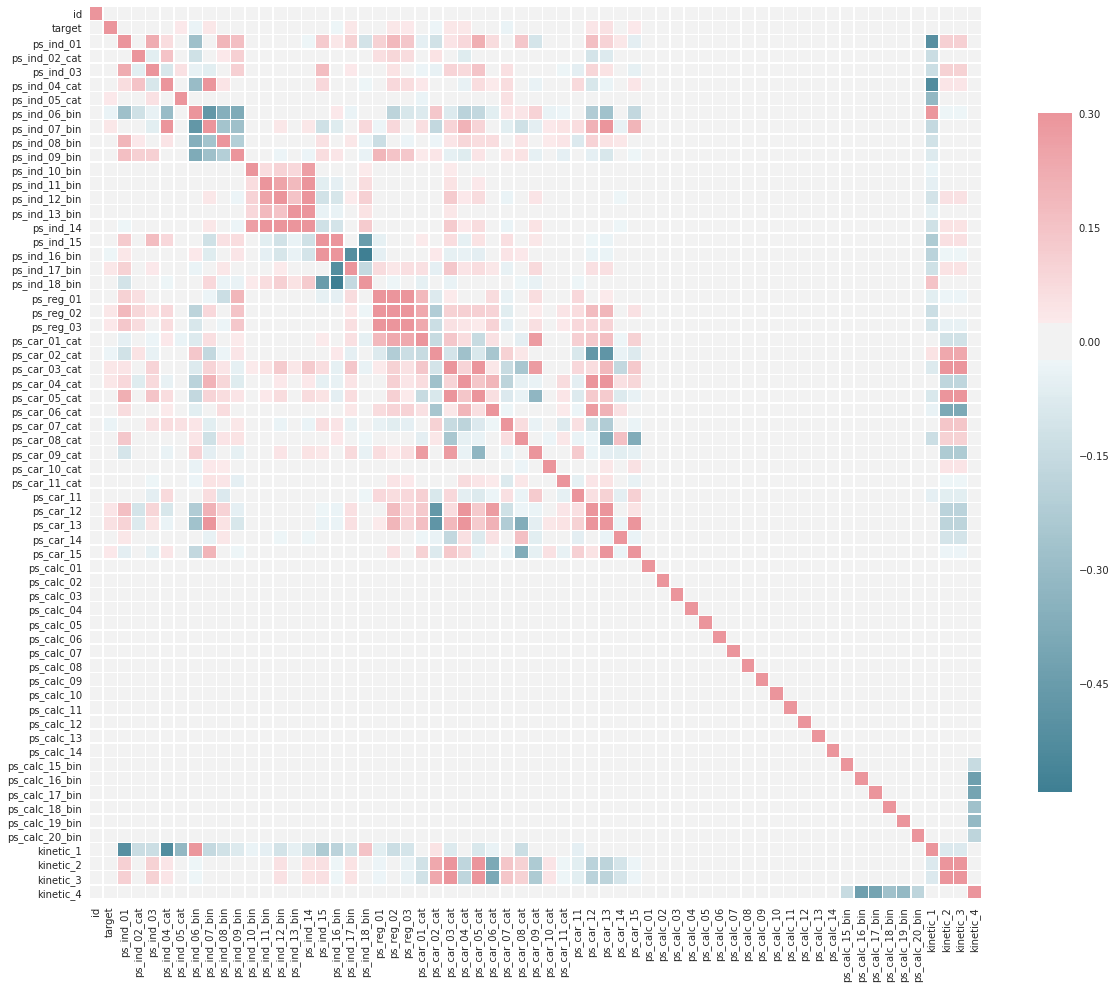

In [6]:
sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Set up the matplotlib figure dimensions
f, ax = plt.subplots(figsize=(20, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Feature Importance

In [7]:
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Get X and y
X = train.drop(['id', 'target'], axis=1).values
y = train['target'].values

params = {'eta': 0.02, 'max_depth': 4, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 99, 'silent': True}

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=99)

d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_valid, y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

mdl = xgb.train(params, d_train, num_boost_round=2000, evals=watchlist,
          early_stopping_rounds=100, feval=gini_xgb,
          maximize=True, verbose_eval=500)

[0]	train-auc:0.590637	valid-auc:0.589366	train-gini:0.183216	valid-gini:0.177962
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[500]	train-auc:0.663723	valid-auc:0.637569	train-gini:0.327447	valid-gini:0.275137
[1000]	train-auc:0.685483	valid-auc:0.638843	train-gini:0.370966	valid-gini:0.277687
Stopping. Best iteration:
[956]	train-auc:0.683698	valid-auc:0.638939	train-gini:0.367395	valid-gini:0.277877



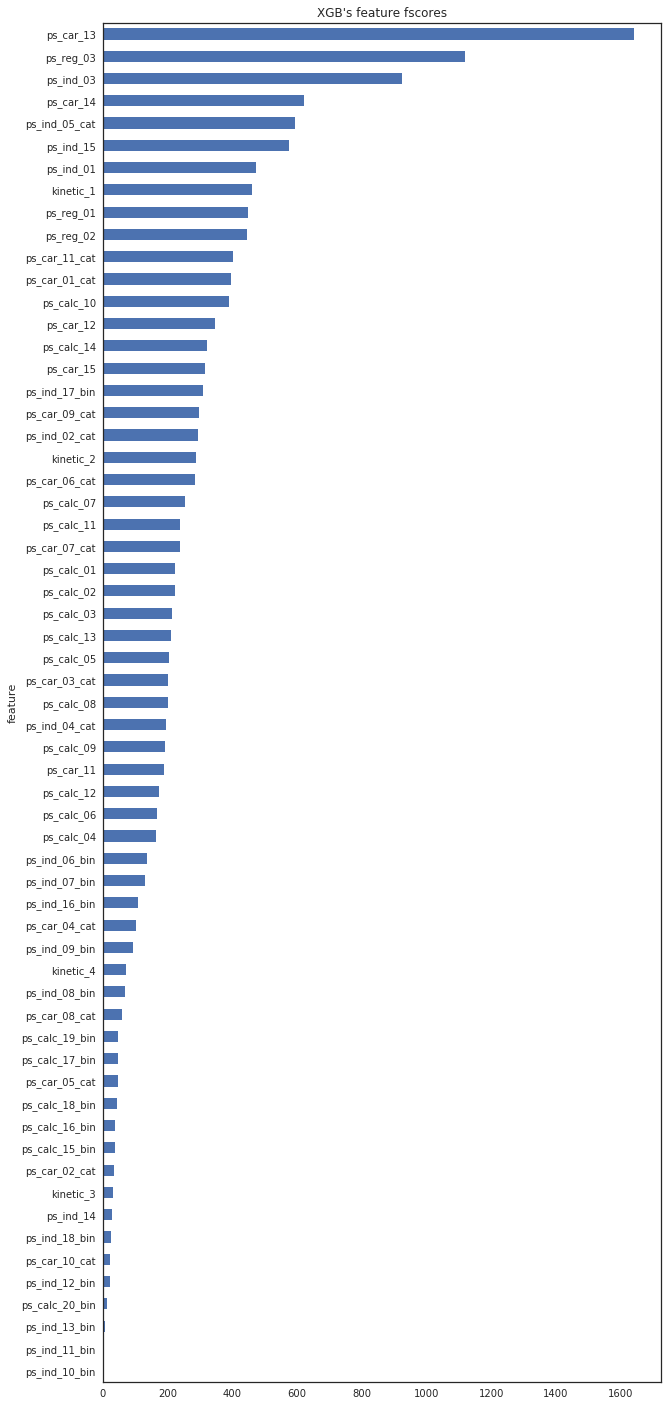

In [9]:
import pandas as pd
# Feature names
feature_names = list(train.drop(['id', 'target'], axis=1).keys())

# Importances 
importances = (sorted(map(lambda x: (int(x[0][1:]), x[1]), mdl.get_fscore().items()), key=lambda x: x[0]))

# Some features may not appear, need to organize
feature2importance = {}
for feat, x in importances:
    feature2importance[feat] = x

feature_names2importances = []
for i, x in enumerate(feature_names):
    if i in feature2importance:
        feature_names2importances.append((x, feature2importance[i]))
    else:
        feature_names2importances.append((x, 0))
        
df = pd.DataFrame(sorted(feature_names2importances, key=lambda x: x[1]), columns=['feature', 'fscore'])
_ = df.plot(title="XGB's feature fscores", kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 25))

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Get rid of NaN -> replace with median value
for key in train.keys():
    train[key].fillna(train[key].median(), inplace=True)
# Get X and y
X = train.drop(['id', 'target'], axis=1).values
y = train['target'].values

mdl = RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=42)
_ = mdl.fit(X, y)

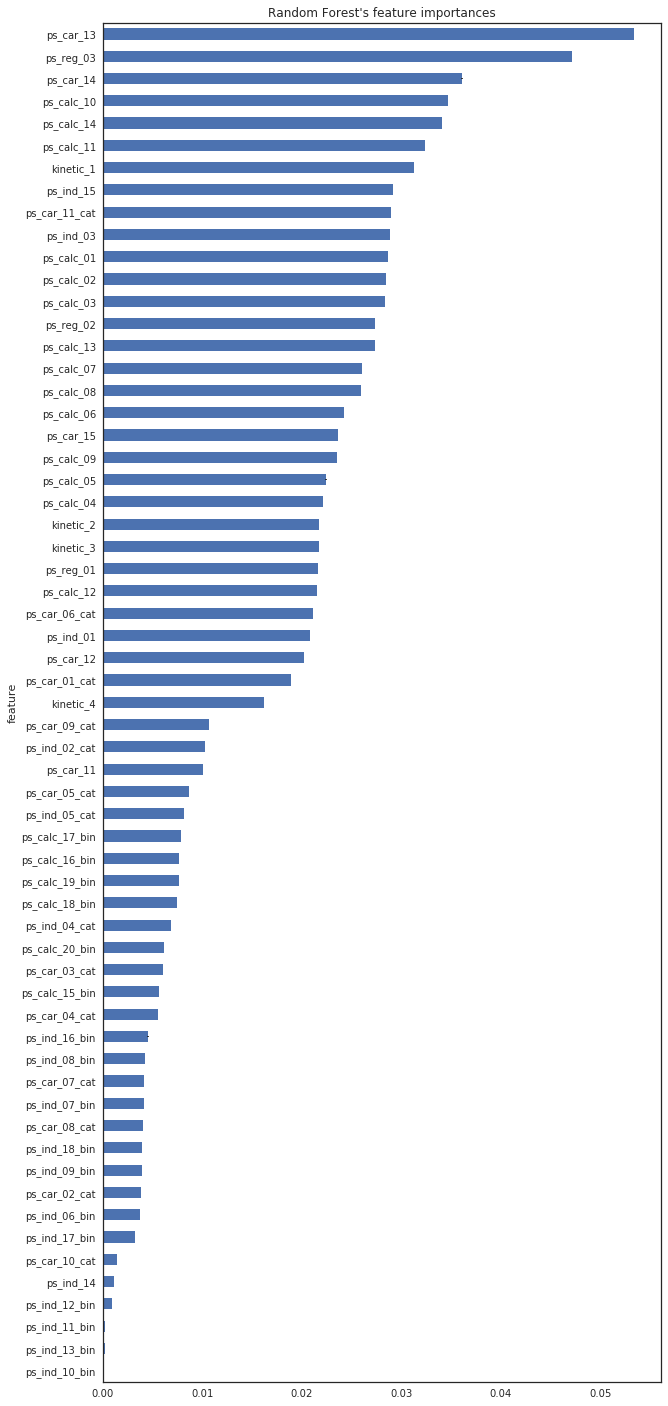

In [11]:
# Feature names
feature_names = list(train.drop(['id', 'target'], axis=1).keys())

# Importances and standard deviation
importances = mdl.feature_importances_
std = np.std([tree.feature_importances_ for tree in mdl.estimators_], axis=0)

assert len(importances) == len(feature_names)

df = pd.DataFrame(sorted(zip(feature_names, importances, std), key=lambda x: x[1]), 
                  columns=['feature', 'fscore', 'std'])
_ = df.plot(title="Random Forest's feature importances", kind='barh', x='feature', y='fscore', yerr='std',
            legend=False, figsize=(10, 25))